<a href="https://colab.research.google.com/github/salmonin-o3o/ESAA_study/blob/main/250616_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

딥러닝 파이토치 교과서
## 7.5 LSTM
RNN은 결정적 단점이 있다. 기울기 소멸 문제이다. 이를 해결하기 위해 LSTM이나 GRU 같은 확장된 RNN 방식들을 사용하고 있다.

### 7.5.1 LSTM 구조
LSTM 구조는 순전파와 역전파 과정으로 살펴본다.

**LSTM 순전파**

LSTM은 기울기 소멸 문제를 해결하기 위해 망각 게이트, 입력 게이트, 출력 게이트라는 새로운 요소를 은닉층의 각 뉴런에 추가했다.

*망각 게이트*

망각 게이트는 과거 정보를 어느 정도 기억할지 결정한다. 과거 정보와 현재 데이터를 입력 받아 시그모이드를 취한 후, 그 출력이 0이면 과거 정보는 버리고, 1이면 과거 정보는 온전히 보존한다.

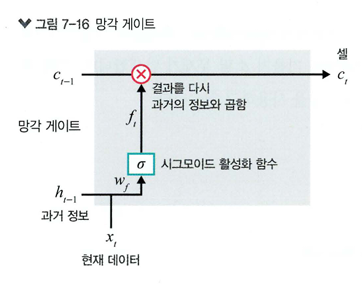

*입력 게이트*

입력 게이트는 현재 정보를 기억하기 위해 만들어졌다. 과거 정보와 현재 데이터를 입력받아 시그모이드와 하이퍼볼릭 탄젠트 함수를 기반으로 형재 정보에 대한 보존략을 결정한다. 즉, 현재 메모리에 새로운 정보를 반영할지 결정하는 역할을 한다.

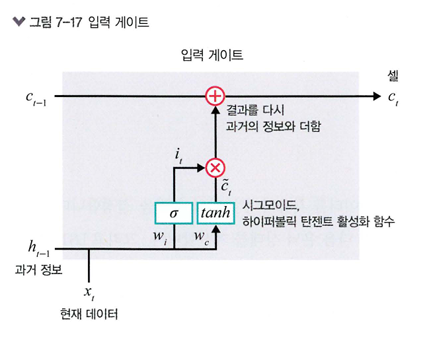

*셀*

각 단계에 대한 은닉 노드를 메모리 셀이라고 한다. sum을 사용하여 셀 값을 반영하며, 이것으로 기울기 소멸 문제가 해결된다.

셀을 업데이트 하는 방법 - 망각 게이트와 입력 게이트의 이전 단계 셀 정보를 계산하여 현재 단계의 셀 상태를 업데이트한다.

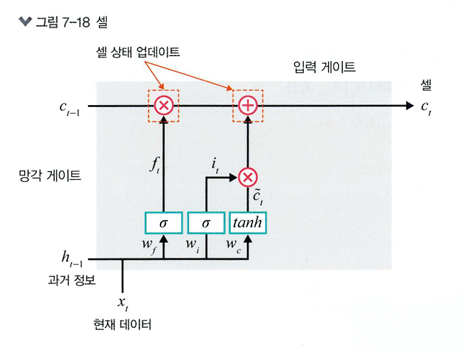

*출력 게이트*

출력 게이트는 과거 정보와 현재 데이터를 사용하여 뉴런의 출력을 결정한다. 이전 은닉 상태와 t번째 입력을 고려해서 다음 은닉 상태를 계산한다. 그리고 LSTM에서는 이 은닉 상태가 그 시점에서의 출력이 된다. 즉, 출력 게이트는 갱신된 메모리의 출력 값을 제어하는 역할을 한다.

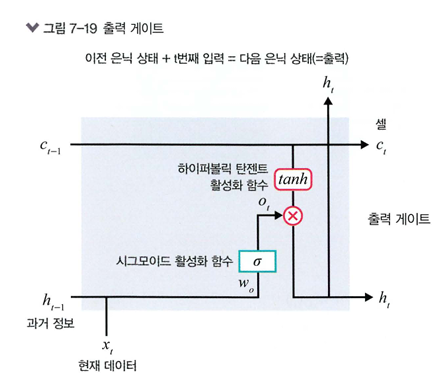

다음은 망각 게이트, 입력 게이트, 출력 게이트를 모두 표현한 것이다.

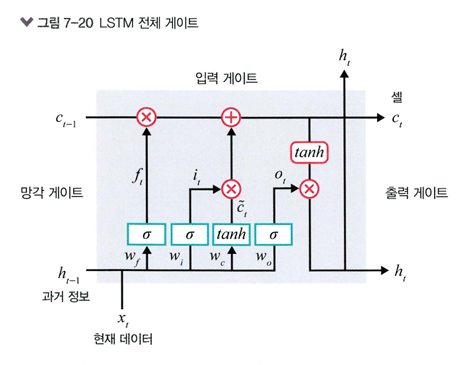

**LSTM 역전파**

LSTM은 셀을 통해서 역전파를 수행한다. 즉, 다음 그림과 같이 최종 오차는 모든 노드에 전파되는데, 이때 셀을 통해서 중단 없이 전파된다.

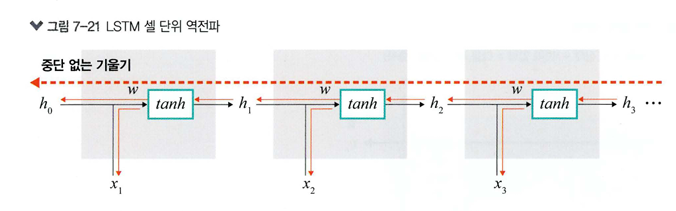

이때 주의해야 할 것은 셀 단위로 오차가 전파된다고 해서 입력 방향으로 오차가 전파되지 ㅏㄶ는 것은 아니다. 다음 그림과 같이 셀 내부적으로는 오차가 입력으로 전파된다는 것도 잊지 말아야 한다.

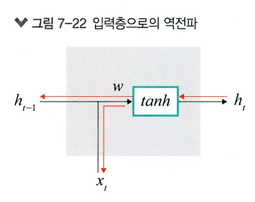

### 7.5.2 LSTM 셀 구현

지금까지 RNN을 살펴보았다면 이제 LSTM 셀과 LSTM 계층을 살펴보자. 이번 예제에서 사용할 데이터셋은 MNIST이다.

In [1]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter # 파라미터 목록을 갖고 있는 라이브러리
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math # 수학과 관련되어 다양한 함수들과 상수들이 정의되어 있는 라이브러리

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False # GPU 사용에 필요
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor # GPU 사용에 필요

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

In [2]:
# 데이터 전처리
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,)) # 평균을 0.5, 표준편차를 1.0으로 데이터 정규화
    ])

In [3]:
# 데이터셋 내려받기
from torchvision.datasets import MNIST

download_root = '../chap07/MNIST_DATASET' # MNIST를 내려받을 경로

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.79MB/s]


데이터로더를 이용하여 내려받은 MNIST 파일을 메모리로 불러온다. 단, train_loader, valid_loader, test_loader가 호출될 때 메모리로 불러온다는 점에 주의하자.

In [4]:
# 데이터셋을 메모리로 가져오기
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# 변수 값 지정
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

LSTM 셀에 대한 네트워크를 구축한다. 모델의 전반적인 네트워크가 아닌 LSTM 셀에 집중한 네트워크이다.

In [6]:
# LSTM 셀 네트워크 구축
class LSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(LSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias) # 곱하기 4를 하는 이유: 게이트가 네 개로 쪼개지는 상황이기 때문
    self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
    self.reset_parameters()

  def reset_parameters(self): # 모델의 파라미터 초기화
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std) # 난수를 위해 사용.

  def forward(self, x, hidden):
    hx, cx = hidden
    x = x.view(-1, x.size(1))

    gates = self.x2h(x) + self.h2h(hx) #망각, 입력, 셀, 출력으로 구성된 게이트를 이렇게 구한다.
    gates = gates.squeeze() # 텐서의 차원을 줄임
    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1) # 계산된 게이트는 네게로 쪼개져서 각각 망각, 입력, 셀, 출력 게이트를 의미하는 변수에 저장된다.

    ingate = F.sigmoid(ingate) # 입력 게이트에 시그모이드 활성화 함수 적용
    forgetgate = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 활성화 함수 적용
    cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 활성화 함수 적용
    outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 활성화 함수 적용

    cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate) # torch.mul()은 텐서에 곱셈을 할 때 사용한다.
    hy = torch.mul(outgate, F.tanh(cy)) # 하나의 LSTM 셀을 통과하면 셀 상태와 은닉 상태가 출력으로 주어진다. 이때 셀 상태는 입력, 망각, 셀 게이트에 의해 계산되며, 은닉 상태는 출력 게이트에 의해 계산된다.
    return (hy, cy)

앞에서 게이트 위주의 셀에 대해 살펴보았으므로 이번에는 전반적인 네트워크를 구성해보자.

In [8]:
# LSTM 셀의 전반적인 네트워크
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim # 은닉층의 뉴런/유닛 개수

    self.layer_dim = layer_dim
    self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim) # LSTM 셀은 앞에서 정의한 함수를 불러오는 부분
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    if torch.cuda.is_available(): # GPU 사용 유무 확인
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()) # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 은닉 상태를 0으로 초기화
    else:
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    if torch.cuda.is_available(): # GPU 사용 유무 확인
      c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()) # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 셀 상태를 0으로 초기화
    else:
      c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

    outs = []
    cn = c0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 셀 상태에 대한 텐서
    hn = h0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 은닉 상태에 대한 텐서

    for seq in range(x.size(1)): #LSTM 셀 계층을 반복하여 쌓아 올린다.
      hn, cn = self.lstm(x[:,seq,:], (hn,cn)) # 은닉 상태(nn)와 셀 상태를 LSTMCell에 저굥ㅇ한 결과를 또다시 hn, cn에 저장
      outs.append(hn)

    out = outs[-1].squeeze()
    out = self.fc(out)
    return out

In [9]:
# 옵티마이저와 손실 함수 지정
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available(): # GPU 사용 유무 확인
  model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# 모델 학습 및 성능 확인
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader): # 훈련 데이터셋을 이용한 모델 학습
    if torch.cuda.is_available(): # GPU 사용 유무 확인
      images = Variable(images.view(-1, seq_dim, input_dim).cuda()) # 현재 버전에서는 모든 텐서가 자동으로 Variable의 성질을 갖기 때문에 torch.autograd.Variable을 사용할 필요가 없다.
      labels = Variable(labels.cuda())
    else: # GPU를 사용하지 않기 때문에 else 구문이 실행
      images = Variable(images.view(-1, seq_dim, input_dim))
      labels = Variable(labels)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels) # 손실 함수를 이용하여 오차 계산

    if torch.cuda.is_available():
      loss.cuda()

    loss.backward()
    optimizer.step() # 파라미터 업데이트
    loss_list.append(loss.item())
    iter += 1

    if iter % 500 == 0: # 정확도 계산
      correct = 0
      total = 0
      for images, labels in valid_loader: # 검증 데이터셋을 이용한 모델 성능 검증

        if torch.cuda.is_available():
          images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
          images = Variable(images.view(-1, seq_dim, input_dim))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # 모델을 통과한 결과의 최댓값으로부터 예측 결과 가져오기

        total += labels.size(0) # 총 레이블 수
        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum()
        else:
          correct += (predicted == labels).sum()

      accuracy = 100 * correct / total
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.1970534324645996. Accuracy: 29.729999542236328
Iteration: 1000. Loss: 0.6066683530807495. Accuracy: 73.66999816894531
Iteration: 1500. Loss: 0.2654463052749634. Accuracy: 90.5199966430664
Iteration: 2000. Loss: 0.5011394023895264. Accuracy: 92.9000015258789
Iteration: 2500. Loss: 0.14519557356834412. Accuracy: 95.05000305175781
Iteration: 3000. Loss: 0.13097615540027618. Accuracy: 95.9800033569336
Iteration: 3500. Loss: 0.0902530625462532. Accuracy: 96.05999755859375
Iteration: 4000. Loss: 0.15322692692279816. Accuracy: 96.5
Iteration: 4500. Loss: 0.0701494961977005. Accuracy: 96.95999908447266
Iteration: 5000. Loss: 0.05970321223139763. Accuracy: 97.61000061035156
Iteration: 5500. Loss: 0.021456144750118256. Accuracy: 97.7300033569336
Iteration: 6000. Loss: 0.0966373160481453. Accuracy: 97.47000122070312
Iteration: 6500. Loss: 0.07837597280740738. Accuracy: 97.70999908447266
Iteration: 7000. Loss: 0.09278272092342377. Accuracy: 98.08999633789062
Iteration: 7500

정확도가 상당히 높다.

In [12]:
# 테스트 데이터셋을 이용한 모델 예측 성능 확인
def evaluate(model, val_iter):
  corrects, total, total_loss = 0, 0, 0
  model.eval()
  for images, labels in val_iter:
    if torch.cuda.is_available(): # GPU 사용 유무 확인
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim)).to(device)

    logit = model(images).to(device)
    loss = F.cross_entropy(logit, labels, reduction='sum') # reduction='sum'을 지정했기 때문에 모든 오차를 더한다.
    _, predicted = torch.max(logit.data, 1) # logit_data 텐서에서 최댓값의 인덱스를 반환
    total += labels.size(0)
    total_loss += loss.item()
    corrects += (predicted == labels).sum()

  avg_loss = total_loss / len(val_iter.dataset)
  avg_accuracy = corrects / total
  return avg_loss, avg_accuracy

모델 학습 및 모델 예측 관련한 코드는 비슷한 패턴으로 진행된다. 따라서 모델의 네트워크 및 네트워크에서 사옹되는 파라미터에 지중하여 학습하면 좋다.

마지막으로 테스트 데이터셋을 이용한 모델 예측 성능을 확인해보자.

In [13]:
# 모델 예측 성능 확인
test_loss, test_acc = evaluate(model, test_loader)
print('Test Loss: %5.2f | Test Accuracy: %5.2f' % (test_loss, test_acc))

Test Loss:  0.08 | Test Accuracy:  0.98


IMDB에서 MNIST로 데이터셋이 바뀌기는 했지만 98%로 성능이 매우 좋다. IMDB는 사전에 전처리가 되지 않은 데이터셋이고, MNIST는 사전에 전처리가 된 상태의 데이터셋이기 때문에 정확도 측면에서 차이가 날 수 있다. 이와 같이 사전에 전처리가 되지 않은 데이터셋의 경우 정확도를 높이기 위해 은닉층의 개수 및 하이퍼파라미터 수정 등이 필요하다.

### 7.5.3 LSTM 계층 구현
LSTM 계층에 대한 예제 데이터셋은 스타벅스 주가 데이터셋을 사용한다. 모델이 얼마나 주가 예측을 잘 하는지에 대해 알아보자.

In [1]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# 데이터셋 가져오기
from google.colab import drive

drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/pythonprogramming/ESAA/25-1/SBUX.csv')
print(data.dtypes)

Mounted at /content/drive
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [4]:
# 날짜 칼럼을 인덱스로 사용
# 날짜 칼럼은 임베딩 처리가 어려우므로 날짜 칼럼을 인덱스로 처리하면 편리
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True) # 'Date' 칼럼을 인덱스로 사용

'Volume'이란 칼럼의 데이터 형식은 정수이므로 이를 실수로 변경한다. 이렇게 하면 추후 데이터를 텐서로 변환할 때 편리하다.

In [5]:
# 데이터 형식 변경
data['Volume'] = data['Volume'].astype(float) # 데이터 형식을 변경할 때는 astype()을 사용

In [6]:
# 훈련과 레이블 분리
X = data.iloc[:, :-1] # 마지막 칼럼을 제외한 모든 칼럼을 x로 사용
y = data.iloc[:, 5:6] # 마지막 'Volume''을 레이블로 사용
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [8]:
# 데이터 분포 조정
ms = MinMaxScaler() # 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler() # 데이터가 평균 0, 분신 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :] # 훈련 데이터셋
X_test = X_ss[200:, :] # 테스트 데이터셋

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


모든 데이터셋은 그 자체로 네트워크에 보낼 수 없다. 네트워크에서 정의된 형태 및 크기에 따라 데이터셋 크기를 조정한 후 네트워크로 보내야한다.

In [9]:
# 데이터셋의 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train)) # Variable로 감싸진 텐서는 .backward()가 호출될 떄 자동으로 기울기가 계산
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1])) # torch.reshape는 텐서의 형태를 바꿀 때 사용
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


이와 같이 데이터셋의 형태를 변경하는 이유는 LSTM 네트워크의 입력 형태와 맞추기 위함.

In [12]:
# LSTM 네트워크
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM, self).__init__()
    self.num_classes = num_classes # 클래스 개수
    self.num_layers = num_layers # LSTM 계층의 개수
    self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
    self.hidden_size = hidden_size # 은닉층의 뉴런 개수
    self.seq_length = seq_length # 시퀀스 길이

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # LSTM 계층
    self.fc_1 = nn.Linear(hidden_size, 128) # 완전연결층
    self.fc = nn.Linear(128, num_classes) # 출력층
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉 상태를 0으로 초기화
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태를 0으로 초기화
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 게층에 은닉 상태와 셀 상태 적용
    hn = hn.view(-1, self.hidden_size) # 완전연결층 적용을 위해 데이터의 형태 조정(1차원으로 조정)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

In [13]:
# 변수 값 설정
num_epochs = 1000 # 1000번의 에포크
learning_rate = 0.0001 # 학습률을 0.0001로 지정

input_size = 5 # 입력 데이터셋의 칼럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1 # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) # 앞에서 정의한 값들을 이용하여 LSTM 모델 학습

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# 모델 학습
for epoch in range(num_epochs): # 1000번 반복
  outputs = model.forward(X_train_tensors_f) # 전방향 학습
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors) # 손실 함수를 이용하여 오차 계산
  loss.backward() # 기울기 계산

  optimizer.step() # 오차 업데이트
  if epoch % 100 == 0: # 1000을 100으로 나누어 나머지가 0이면 출력
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.35176
Epoch: 100, loss: 0.14974
Epoch: 200, loss: 0.06838
Epoch: 300, loss: 0.04422
Epoch: 400, loss: 0.03897
Epoch: 500, loss: 0.03775
Epoch: 600, loss: 0.03699
Epoch: 700, loss: 0.03608
Epoch: 800, loss: 0.03505
Epoch: 900, loss: 0.03435


오차 위주로 출력했기 때문에 실제로 얼마나 잘 예측했는지 알기 어렵다. 예측 결과를 시각적으로 표현해보자.

In [15]:
# 모델 예측 결과를 출력하기 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:, :-1]) # 데이터 정규화
df_y_ms = ms.transform(data.iloc[:, -1:]) # 데이터 정규화

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

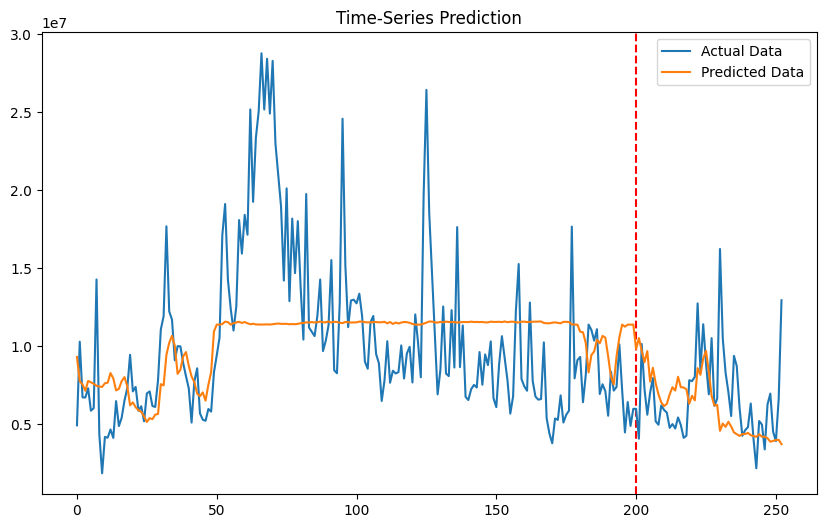

In [16]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss) # 훈련 데이터셋을 모델에 적용하여 모델 학습
predicted = train_predict.data.numpy() # 모델 학습 결과를 넘파이로 변경
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) # 모델 학습을 위해 전처리 했던 것을 해제
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) # 그래프로 표시
plt.axvline(x=200, c='r', linestyle='--') # axvline()은 그래프의 축을 따라 수직선을 표현할 때 사용한다.

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

예측 결과가 만족스럽지 않다.